#Covid 19 with classic forecasting models

In this notebook, we will use multiple tools to make forecasting.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objects as go


In [2]:
df_deaths_us = pd.read_csv('data/time_series_covid19_deaths_global.csv')
df_confirmed_global = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
df_confirmed_us = pd.read_csv('data/time_series_covid19_confirmed_US.csv')
df_recovered_global = pd.read_csv('data/time_series_covid19_recovered_global.csv')

# Classic time series models

In [3]:
df_1 = df_confirmed_us.iloc[1,11:].to_frame().reset_index()
df_1.rename(columns = {'index':'time',1:'cases'}, inplace=True)
df_1['time'] = pd.to_datetime(df_1['time'], format='%m/%d/%y')
df_1['cases'] = df_1['cases'].astype(float)
df_1.set_index('time', inplace=True)

In [4]:
fig = go.Figure([go.Scatter(x = df_1.index, y = df_1['cases'])])
fig.show()

The most common test for identifying whether a time series is non-stationary is the augmented **Dicky-Fuller test**. This is a statistical test, where the **null hypothesis is that your time series is non-stationary due to trend**

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_1['cases'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
  if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
  else:
        print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -0.120827
p-value: 0.947324
Critical Values:
	1%: -3.436
Non-stationary
	5%: -2.864
Non-stationary
	10%: -2.568
Non-stationary


The results object is a tuple. The zeroth element is the test statistic, in this case it is -0.12. The more negative this number is, the more likely that the data is stationary. The next item in the results tuple, is the test p-value. Here it's 0.94. If the p-value is smaller than 0.05, we reject the null hypothesis and assume our time series must be stationary. The last item in the tuple is a dictionary. This stores the critical values of the test statistic which equate to different p-values. In this case, if we wanted a p-value of 0.05 or below, our test statistic needed to be below -2.91.

p-value is high. It should be very less. We fail to reject the null hypothesis as p-value is high. So, the time series is non-stationary.
If p-value is less, then we can say that the time series is stationary.

Remember that Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality).

**If the time series is stationary, continue to the next steps. If the time series is not stationary, try differencing the time series and recheck its stationarity.** Most of the automl (like pycaret or Darts)  packages do this step automatically.

In [6]:
df2 = df_1.diff(periods=1)
df2 = df2.dropna()
result = adfuller(df2['cases'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
  if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
  else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -5.336603
p-value: 0.000005
Critical Values:
	1%: -3.436
Stationary
	5%: -2.864
Stationary
	10%: -2.568
Stationary


In [7]:
fig = go.Figure([go.Scatter(x = df2.index, y = df2['cases'])])
fig.show()

Here the blue area is the confidence interval, and the candles started coming inside after the 13th candle. This can be due to the seasonality of 12-13 months.



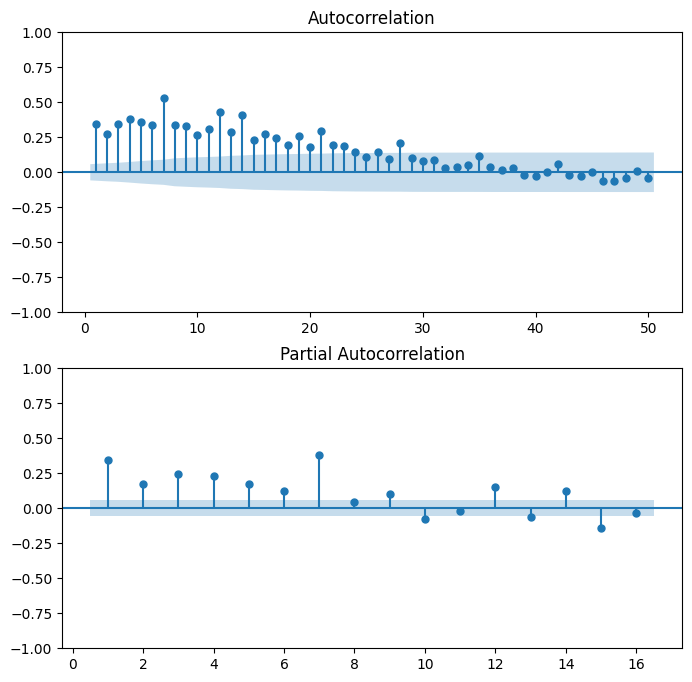

In [8]:
fig, (ax1 ,ax2) = plt.subplots(2,1, figsize = (8,8))
plot_acf(df2, lags = 50, zero =False, ax=ax1)
plot_pacf(df2, lags = 16, zero =False, ax=ax2)
plt.show()

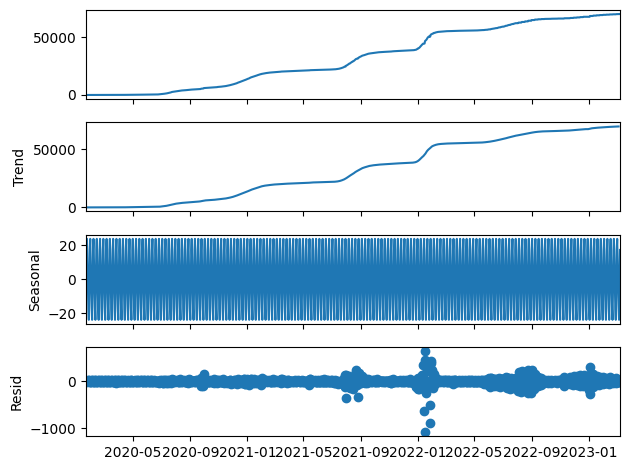

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_1, model='additive')
result.plot()
plt.show()

# pmdarima package

The pmdarima package is a powerful tool to help you choose the model orders. You can use the information you already have from the identification step to narrow down the model orders which you choose by automation.

Remember, although automation is powerful, it can sometimes make mistakes that you wouldn't. It is hard to guess how the input data could be imperfect and affect the test scores.

In this exercise you will use the pmdarima package to automatically choose model orders for some time series datasets.



In [10]:
import pmdarima as pm
from pmdarima import model_selection

In [11]:
train, test = model_selection.train_test_split(df2, train_size= 1000)

# AIC - Akaike information criterion
The Akaike information criterion, or AIC, is a metric which tells us how good a model is. A model which makes better predictions is given a lower AIC score. The AIC also penalizes models which have lots of parameters. This means if we set the order too high compared to the data, we will get a high AIC value. This stops us overfitting to the training data.

# BIC - Bayesian information criterion

The Bayesian information criterion, or BIC, is very similar to the AIC. Models which fit the data better have lower BICs and the BIC penalizes overly complex models.

* The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model.

In [12]:
model2 = pm.auto_arima(train,  # data
                      seasonal= True, # True if true , false if false
                      m=7, # seasonal period
                      #D=1, # seasonal difference order
                      start_P= 0, # initial guess for p
                      start_Q= 0, # initial guess for q
                 	    max_P=3, # max value for p to test
                      max_Q=3, # max value for q to test
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=12149.786, Time=6.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12840.820, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12573.842, Time=1.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12187.085, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12838.821, Time=0.01 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=12106.004, Time=8.04 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=12099.140, Time=9.38 sec
 ARIMA(2,1,2)(3,0,0)[7] intercept   : AIC=12100.160, Time=5.25 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=12099.239, Time=3.07 sec
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=12096.992, Time=1.61 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=12114.409, Time=1.16 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=12098.970, Time=3.12 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=12104.300, Time=2.47 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=12100.648, Time=3.50 sec
 ARIMA(1,1,2)(1,0,1

In [13]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1000
Model:             SARIMAX(1, 1, 4)x(1, 0, [1], 7)   Log Likelihood               -6035.309
Date:                             Thu, 16 Nov 2023   AIC                          12086.619
Time:                                     15:51:19   BIC                          12125.873
Sample:                                 01-23-2020   HQIC                         12101.539
                                      - 10-18-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7725      0.035     22.126      0.000       0.704       0.841
ma.L1         -1.7235      0.039    -44.061      0.000      -1.800      -1.647
ma.L2          0.5741      0.046     12.605      0.000       0.485       0.663
ma.L3          0.2989      0.039      7.574      0.000       0.222       0.376
ma.L4         -0.1001      0.027     -3.731      0.000      -0.153      -0.048
ar.S.L7        0.6910      0.059     11.720      0.000       0.575       0.807
ma.S.L7       -0.5014      0.065     -7.685      0.000      -0.629      -0.373
sigma2      1.032e+04    130.852     78.846      0.000    1.01e+04    1.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            246105.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              19.34   Skew:                             3.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

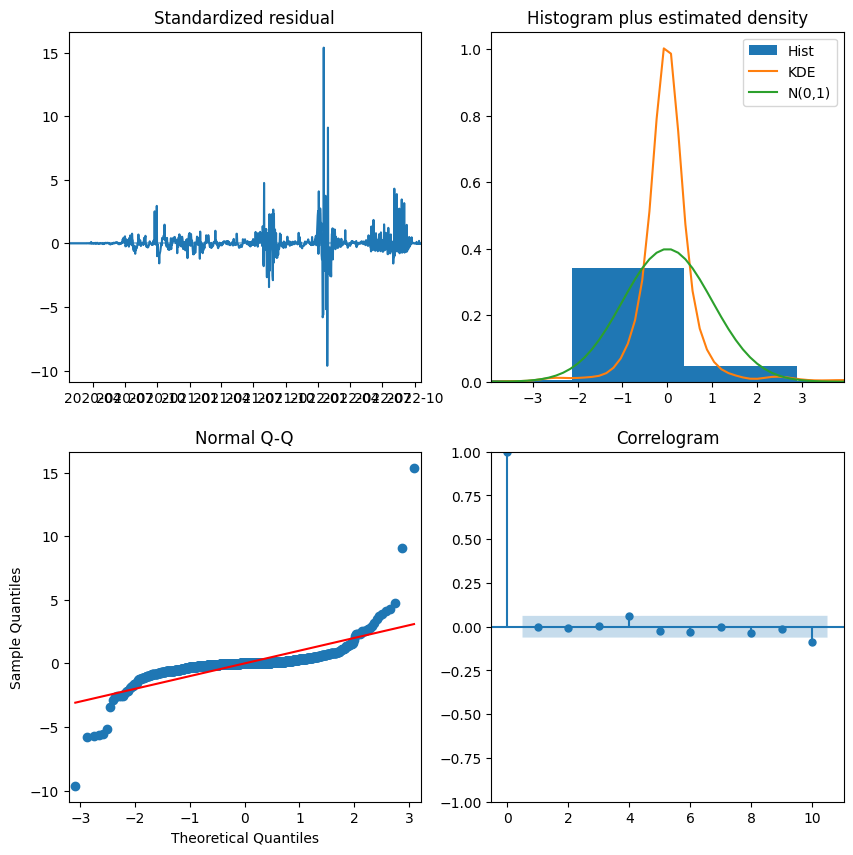

In [14]:
model2.plot_diagnostics(figsize=(10,10))
plt.show()

In [15]:
model2.fit(train)

ARIMA(order=(1, 1, 4), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [16]:
fit_forecast_pred = model2.predict_in_sample(train)
fit_forecast_pred

2020-01-23    0.000000
2020-01-24    0.000000
2020-01-25    0.000000
2020-01-26    0.000000
2020-01-27    0.000000
                ...   
2022-10-14    3.358393
2022-10-15   -0.757979
2022-10-16    3.117848
2022-10-17    2.827997
2022-10-18    3.584492
Freq: D, Name: predicted_mean, Length: 1000, dtype: float64